In [1]:
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
from env.world import NetworkWorld
from env.task import TraversalTask
from model.actor_critic import ActorCritic
from model.reinforce import Reinforce
from model.random_agent import RandomAgent
from model.curious_observer import CuriousObserver, IntuitivePathObserver
from model.trainer import ObserverTrainer, AgentTrainer
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import xarray
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
W1 = {}
W1['edges'] = {0:[14,1,2,3],
               1:[0,2,3,4],
               2:[1,3,4,0],
               3:[2,4,0,1],
               4:[3,5,1,2],
               5:[4,6,7,8],
               6:[5,7,8,9],
               7:[6,8,9,5],
               8:[7,9,5,6],
               9:[8,10,6,7],
               10:[9,11,12,13],
               11:[10,12,13,14],
               12:[11,13,14,10],
               13:[12,14,10,11],
               14:[13,0,11,12]}
W1['nodes'] = np.array(list(W1['edges'].keys()))

W2 = {}
W2['edges'] = {0:[14,3], 1:[0,4], 2:[1,0],
         3:[2,1], 4:[3,2], 5:[4,8],
         6:[5,9], 7:[6,5], 8:[7,6],
         9:[8,7], 10:[9,13], 11:[10,14],
         12:[11,10], 13:[12,11], 14:[13,12]}
W2['nodes'] = np.array(list(W2['edges'].keys()))

W3 = {}
W3['edges'] = {0:[0,1,2,3],
               1:[0,2,3,4],
               2:[1,3,4,0],
               3:[2,4,0,1],
               4:[3,4,1,2],
               5:[5,6,7,8],
               6:[5,7,8,9],
               7:[6,8,9,5],
               8:[7,9,5,6],
               9:[8,10,6,7],
               10:[9,11,12,13],
               11:[10,12,13,14],
               12:[11,13,14,10],
               13:[12,14,10,11],
               14:[13,14,11,12]}
W3['nodes'] = np.array(list(W3['edges'].keys()))

W4 = {}
W4['edges'] = {0:[0,3], 1:[0,4], 2:[1,0],
         3:[2,1], 4:[3,2], 5:[5,8],
         6:[5,9], 7:[6,5], 8:[7,6],
         9:[8,7], 10:[9,13], 11:[10,14],
         12:[11,10], 13:[12,11], 14:[13,12]}
W4['nodes'] = np.array(list(W2['edges'].keys()))

w1 = NetworkWorld(W1['nodes'], W1['edges'], action_dim=4)
w2 = NetworkWorld(W2['nodes'], W2['edges'], action_dim=2)
w3 = NetworkWorld(W3['nodes'], W3['edges'], action_dim=4)
w4 = NetworkWorld(W4['nodes'], W4['edges'], action_dim=2)

### observer intuition test

In [3]:
def collect_data(batch_size, world):
    # in w3/w4, about 52% of the time the two randomly sampled nodes are connected
    data = []
    for _ in range(batch_size):
        s1, s2 = np.random.choice(world.nodes, 2, replace=False)
        connected = nx.has_path(world.graph, s1, s2) or nx.has_path(world.graph, s2, s1)
        data.append([s1, s2, int(connected)])
        
    return np.array(data)

In [9]:
def train_connection_test(world, log_dir, n_epochs, log_interval, prior_knowledge=None):
    writer = SummaryWriter(log_dir)
    new_observer = IntuitivePathObserver(15, 15, 2, 50)
    if prior_knowledge is not None:
        new_observer.fc1_1.load_state_dict(prior_knowledge.state_dict())
        new_observer.fc1_2.load_state_dict(prior_knowledge.state_dict())
    for i in range(n_epochs):
        data = collect_data(10, world)
        s1 = torch.tensor(data[:, 0])
        s2 = torch.tensor(data[:, 1])
        c = torch.tensor(data[:, -1])
        X1 = nn.functional.one_hot(s1, 15).type('torch.FloatTensor')
        X2 = nn.functional.one_hot(s2, 15).type('torch.FloatTensor')
        
        loss = new_observer.train(X1, X2, c)
        
        if i%log_interval==0:
#             print(loss)
            writer.add_scalar('observer_train_loss', loss, i)

In [5]:
for i in range(20):
    print(i, end=', ')
    log_dir = '/data5/liyuxuan/cupla/runs/observer_world3_connection_run%d_'%i+datetime.now().strftime('%y%m%d%H%M')
    train_connection_test(w3, log_dir, 1000, 10, prior_knowledge=None)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

In [6]:
for i in range(20):
    print(i, end=', ')
    env = TraversalTask(world=w3, start=0, goal=9, min_dist=1,
                    change_start_on_reset=True, change_goal_on_reset=True,
                    goal_conditioned_obs=False, reward='sparse')
    w3ss = CuriousObserver(15, 15, 50)
    t = ObserverTrainer(env, w3ss, mode='ss')
    t.train(1000, 10, 10, verbose=False)
    log_dir = '/data5/liyuxuan/cupla/runs/observer_world3_connection_fc1_1_run%d_'%i+datetime.now().strftime('%y%m%d%H%M')
    train_connection_test(w3, log_dir, 1000, 10, prior_knowledge=w3ss.fc1[0])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

In [10]:
for i in range(20):
    print(i, end=', ')
    env = TraversalTask(world=w3, start=0, goal=9, min_dist=1,
                    change_start_on_reset=True, change_goal_on_reset=True,
                    goal_conditioned_obs=False, reward='sparse')
    w3ss = CuriousObserver(15, 15, 50)
    t = ObserverTrainer(env, w3ss, mode='ss')
    t.train(1000, 10, 10, verbose=False)
    log_dir = '/data5/liyuxuan/cupla/runs/observer_world3_connection_fc1_run%d_'%i+datetime.now().strftime('%y%m%d%H%M')
    train_connection_test(w3, log_dir, 1000, 10, prior_knowledge=w3ss.fc1[0])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

In [7]:
for i in range(20):
    print(i, end=', ')
    log_dir = '/data5/liyuxuan/cupla/runs/observer_world4_connection_run%d_'%i+datetime.now().strftime('%y%m%d%H%M')
    train_connection_test(w4, log_dir, 1000, 10, prior_knowledge=None)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

In [8]:
for i in range(20):
    print(i, end=', ')
    env = TraversalTask(world=w4, start=0, goal=9, min_dist=1,
                    change_start_on_reset=True, change_goal_on_reset=True,
                    goal_conditioned_obs=False, reward='sparse')
    w4ss = CuriousObserver(15, 15, 50)
    t = ObserverTrainer(env, w4ss, mode='ss')
    t.train(1000, 10, 10, verbose=False)
    log_dir = '/data5/liyuxuan/cupla/runs/observer_world4_connection_fc1_1_run%d_'%i+datetime.now().strftime('%y%m%d%H%M')
    train_connection_test(w4, log_dir, 1000, 10, prior_knowledge=w4ss.fc1[0])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

In [11]:
for i in range(20):
    print(i, end=', ')
    env = TraversalTask(world=w4, start=0, goal=9, min_dist=1,
                    change_start_on_reset=True, change_goal_on_reset=True,
                    goal_conditioned_obs=False, reward='sparse')
    w4ss = CuriousObserver(15, 15, 50)
    t = ObserverTrainer(env, w4ss, mode='ss')
    t.train(1000, 10, 10, verbose=False)
    log_dir = '/data5/liyuxuan/cupla/runs/observer_world4_connection_fc1_run%d_'%i+datetime.now().strftime('%y%m%d%H%M')
    train_connection_test(w4, log_dir, 1000, 10, prior_knowledge=w4ss.fc1[0])

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 

### train observers

In [5]:
env = TraversalTask(world=w1, start=0, goal=9,
                    change_start_on_reset=True, change_goal_on_reset=True,
                    goal_conditioned_obs=False, reward='sparse')
w1ss = CuriousObserver(15, 15, 50)
t = ObserverTrainer(env, w1ss, mode='ss')
t.train(1000, 10, 10, verbose=True)

epoch: 0  |  loss: 2.663426
epoch: 100  |  loss: 1.221960
epoch: 200  |  loss: 1.524009
epoch: 300  |  loss: 1.335851
epoch: 400  |  loss: 1.407893
epoch: 500  |  loss: 1.556033
epoch: 600  |  loss: 1.396828
epoch: 700  |  loss: 1.572080
epoch: 800  |  loss: 1.592233
epoch: 900  |  loss: 1.325324


In [9]:
env = TraversalTask(world=w1, start=0, goal=9,
                    change_start_on_reset=True, change_goal_on_reset=True,
                    goal_conditioned_obs=False, reward='sparse')
w1sas = CuriousObserver(19, 15, 50)
t = ObserverTrainer(env, w1sas, mode='sas')
t.train(1000, 10, 10, verbose=True)

epoch: 0  |  loss: 2.734237
epoch: 100  |  loss: 0.233472
epoch: 200  |  loss: 0.017296
epoch: 300  |  loss: 0.009475
epoch: 400  |  loss: 0.004413
epoch: 500  |  loss: 0.003067
epoch: 600  |  loss: 0.002411
epoch: 700  |  loss: 0.001853
epoch: 800  |  loss: 0.001327
epoch: 900  |  loss: 0.001058


In [107]:
env = TraversalTask(world=w2, start=0, goal=9,
                    change_start_on_reset=True, change_goal_on_reset=True,
                    goal_conditioned_obs=False, reward='sparse')
w2ss = CuriousObserver(15, 15, 50)
t = ObserverTrainer(env, w2ss, mode='ss')
t.train(1000, 10, 10, verbose=True)

epoch: 0  |  loss: 2.728077
epoch: 100  |  loss: 1.155284
epoch: 200  |  loss: 0.732807
epoch: 300  |  loss: 0.888469
epoch: 400  |  loss: 0.697166
epoch: 500  |  loss: 0.652608
epoch: 600  |  loss: 0.743463
epoch: 700  |  loss: 0.758982
epoch: 800  |  loss: 0.803531
epoch: 900  |  loss: 0.909086


In [108]:
env = TraversalTask(world=w2, start=0, goal=9,
                    change_start_on_reset=True, change_goal_on_reset=True,
                    goal_conditioned_obs=False, reward='sparse')
w2sas = CuriousObserver(17, 15, 50)
t = ObserverTrainer(env, w2sas, mode='sas')
t.train(1000, 10, 10, verbose=True)

/home/liyuxuan/github/curious_planner/model/trainer.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = nn.functional.one_hot(torch.tensor(actions), self.env.action_dim).type('torch.FloatTensor')


epoch: 0  |  loss: 2.722831
epoch: 100  |  loss: 0.022917
epoch: 200  |  loss: 0.004591
epoch: 300  |  loss: 0.002785
epoch: 400  |  loss: 0.001586
epoch: 500  |  loss: 0.001011
epoch: 600  |  loss: 0.000940
epoch: 700  |  loss: 0.000575
epoch: 800  |  loss: 0.000517
epoch: 900  |  loss: 0.000326


In [8]:
env = TraversalTask(world=w3, start=0, goal=9, min_dist=1,
                    change_start_on_reset=True, change_goal_on_reset=True,
                    goal_conditioned_obs=False, reward='sparse')
w3ss = CuriousObserver(15, 15, 50)
t = ObserverTrainer(env, w3ss, mode='ss')
t.train(1000, 10, 10, verbose=False)

In [4]:
env = TraversalTask(world=w3, start=0, goal=9, min_dist=1,
                    change_start_on_reset=True, change_goal_on_reset=True,
                    goal_conditioned_obs=False, reward='sparse')
w3sas = CuriousObserver(19, 15, 50)
t = ObserverTrainer(env, w3sas, mode='sas')
t.train(1000, 10, 10, verbose=False)

/home/liyuxuan/github/curious_planner/model/trainer.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actions = nn.functional.one_hot(torch.tensor(actions), self.env.action_dim).type('torch.FloatTensor')


epoch: 0  |  loss: 2.695432
epoch: 100  |  loss: 0.237070
epoch: 200  |  loss: 0.025619
epoch: 300  |  loss: 0.010012
epoch: 400  |  loss: 0.005136
epoch: 500  |  loss: 0.003794
epoch: 600  |  loss: 0.003082
epoch: 700  |  loss: 0.001761
epoch: 800  |  loss: 0.001445
epoch: 900  |  loss: 0.001090


In [9]:
env = TraversalTask(world=w4, start=0, goal=9, min_dist=1,
                    change_start_on_reset=True, change_goal_on_reset=True,
                    goal_conditioned_obs=False, reward='sparse')
w4ss = CuriousObserver(15, 15, 50)
t = ObserverTrainer(env, w4ss, mode='ss')
t.train(1000, 10, 10, verbose=False)

In [6]:
env = TraversalTask(world=w4, start=0, goal=9,
                    change_start_on_reset=True, change_goal_on_reset=True,
                    goal_conditioned_obs=False, reward='sparse')
w4sas = CuriousObserver(17, 15, 50)
t = ObserverTrainer(env, w4sas, mode='sas')
t.train(1000, 10, 10, verbose=False)

In [238]:
# verify that they work

def check_ss_result(world, observer):
    edges = world.edges
    eval_s = torch.tensor(np.arange(15))
    yhat = []
    for s in eval_s:
        s = torch.nn.functional.one_hot(s, 15).type('torch.FloatTensor')
        yhat.append(observer(s).data.numpy())
    yhat = np.array(yhat)
    
    fig, axes = plt.subplots(5, 3, sharey=True, sharex=True, figsize=[12, 8])

    for i in range(15):
        axes[i%5, int(i/5)].plot(yhat[i, :], label='node %d'%i)
        axes[i%5, int(i/5)].legend()

    axes[0,0].set_xticks(range(15))
    axes[4,0].set_ylabel('yhat')

    fig.tight_layout()

def check_ssa_result(world, observer, target_action):
    edges = world.edges
    eval_s = torch.tensor(np.arange(15))
    yhat = []
    for a in range(env.action_dim):
        ns = torch.tensor([edges[s][a] for s in eval_s.data.numpy()])
        eval_X = torch.cat((torch.nn.functional.one_hot(eval_s, 15).type('torch.FloatTensor'),
                            torch.nn.functional.one_hot(ns, 15).type('torch.FloatTensor')),
                            dim=1)
        yhat.append(observer(eval_X).data.numpy())
    yhat = np.array(yhat)
    
    fig, axes = plt.subplots(5, 3, sharey=True, sharex=True, figsize=[12, 8])

    for i in range(15):
        axes[i%5, int(i/5)].plot(yhat[target_action, i, :], label='node %d'%i)
        axes[i%5, int(i/5)].legend()

    axes[0,0].set_xticks(range(env.action_dim))
    axes[4,0].set_ylabel('yhat')

    fig.tight_layout()
    
def check_sas_result(world, observer, target_action):
    edges = world.edges
    eval_s = torch.tensor(np.arange(15))
    yhat = []
    for a in range(env.action_dim):
        a_tiled = torch.tensor(np.tile(a, len(eval_s)))
        ns = torch.tensor([edges[s][a] for s in eval_s.data.numpy()])
        eval_X = torch.cat((torch.nn.functional.one_hot(eval_s, 15).type('torch.FloatTensor'),
                            torch.nn.functional.one_hot(a_tiled, env.action_dim).type('torch.FloatTensor')),
                            dim=1)
        yhat.append(observer(eval_X).data.numpy())
    yhat = np.array(yhat)
    
    fig, axes = plt.subplots(5, 3, sharey=True, sharex=True, figsize=[12, 8])

    for i in range(15):
        axes[i%5, int(i/5)].plot(yhat[target_action, i, :], label='node %d'%i)
        axes[i%5, int(i/5)].legend()

    axes[0,0].set_xticks(range(15))
    axes[4,0].set_ylabel('yhat')

    fig.tight_layout()

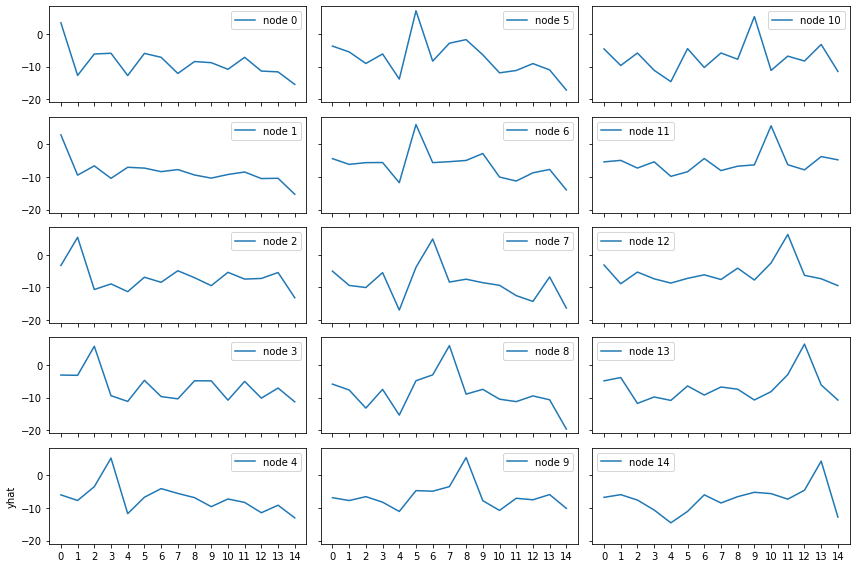

In [239]:
check_sas_result(w4, w4sas, 0)

### observer hidden representation

In [212]:
def check_ss_hiddens(world, observer):
    edges = world.edges
    eval_s = torch.tensor(np.arange(15))
    hidden_layer = []
    for s in eval_s:
        s = torch.nn.functional.one_hot(s, 15).type('torch.FloatTensor')
        hidden_layer.append(observer.fc1(s).data.numpy())
    hidden_layer = np.array(hidden_layer)
    return hidden_layer

def check_sas_hiddens(world, observer):
    edges = world.edges
    eval_s = torch.tensor(np.arange(15))
    hidden_layer = []
    for a in range(world.action_dim):
        a_tiled = torch.tensor(np.tile(a, len(eval_s)))
        ns = torch.tensor([edges[s][a] for s in eval_s.data.numpy()])
        eval_X = torch.cat((torch.nn.functional.one_hot(eval_s, 15).type('torch.FloatTensor'),
                            torch.nn.functional.one_hot(a_tiled, world.action_dim).type('torch.FloatTensor')),
                            dim=1)
        hidden_layer.append(observer.fc1(eval_X).data.numpy())
    hidden_layer = np.array(hidden_layer)
        
    return hidden_layer

def visualize_community_structure(distance_matrix, N=15):
    mds_coords = MDS(n_components=2).fit_transform(distance_matrix)
    
    fig, ax = plt.subplots(figsize=[6,4])
    for i in range(N):
        if i < 5:
            c = 'C1'
            a = 0.4 if i in [0,4] else 0.8 
        elif i < 10:
            c = 'C2'
            a = 0.4 if i in [5,9] else 0.8
        else:
            c = 'C4'
            a = 0.4 if i in [10,14] else 0.8
        ax.text(mds_coords[i,0], mds_coords[i,1], '%d'%i,
                ha='center', va='center')
        ax.scatter(mds_coords[i,0], mds_coords[i,1], 
                   color=c, alpha=a, s=160)

(15, 50)


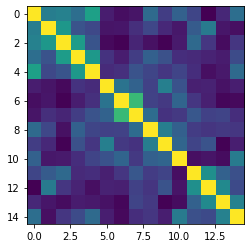

In [240]:
hiddens = check_ss_hiddens(w4, w4ss)
print(hiddens.shape)
distmat = np.array([cosine_similarity([hiddens[i,:]], hiddens)[0] 
                    for i in range(15)])
plt.imshow(distmat)

/home/liyuxuan/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


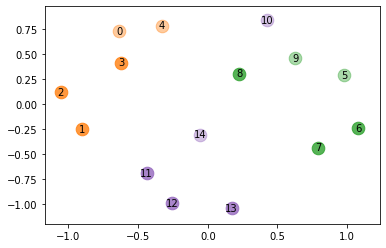

In [248]:
visualize_community_structure(distmat)

(2, 15, 50)
Coordinates:
  * action_node  (action_node) MultiIndex
  - action       (action_node) int64 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1
  - node         (action_node) int64 0 1 2 3 4 5 6 7 8 ... 7 8 9 10 11 12 13 14


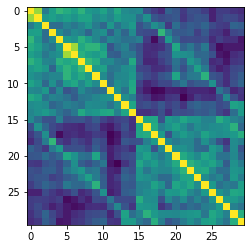

In [250]:
hiddens = check_sas_hiddens(w4, w4sas)
print(hiddens.shape)
hiddens = xarray.DataArray(hiddens, coords={'action':list(range(2)), 
                                            'node':list(range(15)),
                                            'hid':list(range(50))},
                           dims=['action', 'node', 'hid'])
hiddens = hiddens.stack(action_node=('action', 'node')).transpose('action_node', 'hid')
distmat = np.array([cosine_similarity([h], hiddens)[0] for h in hiddens])
print(hiddens.action_node.coords)
plt.imshow(distmat)

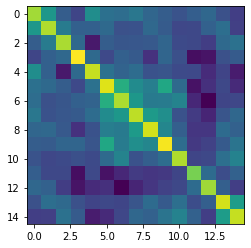

In [251]:
plt.imshow(distmat.reshape((2,15,2,15)).mean((0,2)))

/home/liyuxuan/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


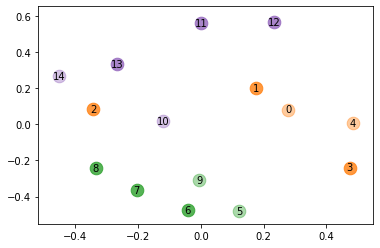

In [271]:
visualize_community_structure(distmat.reshape((2,15,2,15)).mean((0,2))) # 15x15

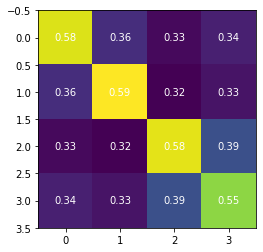

In [194]:
x = distmat.reshape((4,15,4,15)).mean((1,-1))
fig, ax = plt.subplots()
ax.imshow(x)
for i in range(4):
    for j in range(4):
        text = ax.text(j, i, '%.2f'%x[i, j],
                       ha="center", va="center", color="w")

/home/liyuxuan/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


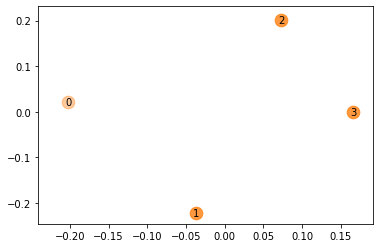

In [199]:
visualize_community_structure(distmat.reshape((4,15,4,15)).mean((1,-1)),
                              N=4) # 4x4